## **Singapore House Resale Price Prediction**

In Singapore, the housing development board provides apartments of different sizes which can be leased by Singapore citizens and Permanent Residents for a period of 100 years. The resale of these apartments for the remaining period of the lease also happens regularly and detailed data on the resale transactions is made available publicly.

<p>
  <img src=https://upload.wikimedia.org/wikipedia/commons/d/d3/HDB_flats_in_Singapore_2.jpg width= 34% />
  <img src=https://www.asiaone.com/sites/default/files/original_images/Jul2017/hdbflats_040717_st.jpg width=25.5% /> 
  <img src=https://www.renonation.sg/wp-content/uploads/The-80s-Studio-Tampines-HDB-Maisonette-8.jpg width=27% />  
</p>

In this project, we will try to build a regression model that can predict the resale prices for different apartments based on features like its location(i.e. the town in which it is located), the number of rooms, the floor area etc.

Before we start, let's import the basic packages we require for importing, handling and visualising the data.

## Importing Data and Preliminary Analysis

In [3]:
%%html
<style>
.output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
    overflow: scroll;
}
</style>

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

The data has been downloaded from a [Singapore government website](https://data.gov.sg/dataset/resale-flat-prices "Data Source for the project") and has been stored locally on the system. We will import the data as a pandas dataframe.

In [13]:
df = pd.read_csv('resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv')

In [14]:
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0
3,2017-01,ANG MO KIO,3 ROOM,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0
4,2017-01,ANG MO KIO,3 ROOM,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0


We have **11 columns** in our data set and we are trying to predict the **resale price**. First let's have a basic overview of the data

In [15]:
df.describe(include='all')

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price
count,70104,70104,70104,70104,70104,70104,70104.000000,70104,70104.000000,70104,7.010400e+04
unique,39,26,7,2409,543,17,NaN,20,NaN,616,NaN
top,2018-07,WOODLANDS,4 ROOM,8,YISHUN RING RD,04 TO 06,NaN,Model A,NaN,94 years 10 months,NaN
freq,2539,5543,29132,241,1124,16243,NaN,22817,NaN,509,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,97.713782,NaN,1993.795261,NaN,4.383990e+05
std,NaN,NaN,NaN,NaN,NaN,NaN,24.243663,NaN,12.584658,NaN,1.533185e+05
min,NaN,NaN,NaN,NaN,NaN,NaN,31.000000,NaN,1966.000000,NaN,1.400000e+05
25%,NaN,NaN,NaN,NaN,NaN,NaN,82.000000,NaN,1984.000000,NaN,3.288880e+05
50%,NaN,NaN,NaN,NaN,NaN,NaN,95.000000,NaN,1993.000000,NaN,4.070000e+05
75%,NaN,NaN,NaN,NaN,NaN,NaN,112.000000,NaN,2003.000000,NaN,5.100000e+05


Fortunately, there is no missing data. But as we can see most of the columns are in the object format and not float or int. And it seems that the data might require some cleaning. Let's consider the different columns and do the necessary preprocessing.

In [16]:
df.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

## Exploratory Data Analysis and Data Wrangling

The flat type with the the number of rooms is stored as a string. First let's check what all are the values stored in the column.

In [17]:
df.groupby(['flat_type']).mean()

,floor_area_sqm,lease_commence_date,resale_price
flat_type,,,
1 ROOM,31.000000,1975.000000,183789.625000
2 ROOM,45.949087,1996.581172,233364.777137
3 ROOM,68.265799,1984.365261,307356.564567
4 ROOM,95.489984,1997.218214,432209.129394
5 ROOM,118.179967,1997.184915,528232.292763
EXECUTIVE,144.404515,1993.559835,625316.397820
MULTI-GENERATION,164.818182,1987.060606,806804.606061


From the Singapore housing development board website, we can see that **'Executive' and 'Mult-Generation'** are larger flats with **6 and 7 rooms respectively** (Note that Multi-Generation rooms have a 'study room' which can be customised which has been counted as a room. Also note the room count given under this feature includes bedrooms, living room, dining room and kitchen and not only the bedrooms). 

So let's change the 'flat_type' feature accordingly and also convert into it into a numerical feature as there is a clear proportionality between this feature and the target variable.

In [18]:
df['flat_type'].replace('EXECUTIVE','6 ROOM', inplace = True)
df['flat_type'].replace('MULTI-GENERATION','7 ROOM', inplace = True)

In [19]:
df.groupby(['flat_type']).mean()

,floor_area_sqm,lease_commence_date,resale_price
flat_type,,,
1 ROOM,31.000000,1975.000000,183789.625000
2 ROOM,45.949087,1996.581172,233364.777137
3 ROOM,68.265799,1984.365261,307356.564567
4 ROOM,95.489984,1997.218214,432209.129394
5 ROOM,118.179967,1997.184915,528232.292763
6 ROOM,144.404515,1993.559835,625316.397820
7 ROOM,164.818182,1987.060606,806804.606061


In [20]:
df['flat_type'] = df['flat_type'].str.replace(' ROOM','')
df['flat_type'] = df['flat_type'].astype(int)

In [21]:
df.dtypes

month                   object
town                    object
flat_type                int64
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
remaining_lease         object
resale_price           float64
dtype: object

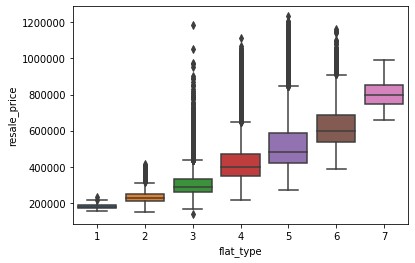

In [22]:
sns.boxplot(x='flat_type', y = 'resale_price', data = df)

Now let's check the feature **'storey_range'**

In [23]:
df.groupby('storey_range').mean()

,flat_type,floor_area_sqm,lease_commence_date,resale_price
storey_range,,,,
01 TO 03,4.087262,97.540975,1990.955093,3.938169e+05
04 TO 06,4.099612,97.266675,1991.812781,4.118815e+05
07 TO 09,4.094992,97.028692,1992.267547,4.233009e+05
10 TO 12,4.141745,97.947149,1993.384074,4.378607e+05
13 TO 15,4.273636,99.258786,1999.808148,4.731559e+05
16 TO 18,4.277285,98.907913,2001.494202,5.139122e+05
19 TO 21,4.261574,99.271605,1999.882716,5.893615e+05
22 TO 24,4.303983,100.040881,2001.302935,6.057925e+05
25 TO 27,4.264078,98.166990,2004.335922,6.616944e+05


One thing to notice is that the mean resale price is going up with increase in the storey. So this is an ordinal varaiable and hence we will to transform it so that the effect can be captured.

The lease commence date and the remaining lease are redundant features as the lease is for a 100 years. We will the remaining lease feature for our analysis as by doing that, we can combine the information from the 'month of sale' and 'lease commence date' into a single feature.

We will convert the years+months format into a the number of months.

In [24]:
df['rem_months'] = 12 * df['remaining_lease'].str.slice(0,2).astype(int) + df['remaining_lease'].str.slice(9,11).replace('',0).replace('0 ',0).astype(int)
df.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,rem_months
0,2017-01,ANG MO KIO,2,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,736
1,2017-01,ANG MO KIO,3,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,727
2,2017-01,ANG MO KIO,3,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,749
3,2017-01,ANG MO KIO,3,465,ANG MO KIO AVE 10,04 TO 06,68.0,New Generation,1980,62 years 01 month,265000.0,745
4,2017-01,ANG MO KIO,3,601,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,265000.0,749


We will drop the columns month, street name, lease commence date and remaining lease and block from our data frame

In [25]:
df_cleaned = df.drop(columns = {'month','street_name','lease_commence_date','remaining_lease', 'block'})
df_cleaned.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,resale_price,rem_months
0,ANG MO KIO,2,10 TO 12,44.0,Improved,232000.0,736
1,ANG MO KIO,3,01 TO 03,67.0,New Generation,250000.0,727
2,ANG MO KIO,3,01 TO 03,67.0,New Generation,262000.0,749
3,ANG MO KIO,3,04 TO 06,68.0,New Generation,265000.0,745
4,ANG MO KIO,3,01 TO 03,67.0,New Generation,265000.0,749


In [26]:
df_cleaned = df_cleaned[['town', 'flat_type', 'storey_range', 'floor_area_sqm', 'flat_model',
       'rem_months', 'resale_price']]
df_cleaned.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,rem_months,resale_price
0,ANG MO KIO,2,10 TO 12,44.0,Improved,736,232000.0
1,ANG MO KIO,3,01 TO 03,67.0,New Generation,727,250000.0
2,ANG MO KIO,3,01 TO 03,67.0,New Generation,749,262000.0
3,ANG MO KIO,3,04 TO 06,68.0,New Generation,745,265000.0
4,ANG MO KIO,3,01 TO 03,67.0,New Generation,749,265000.0


As discussed earlier, we will transfrom the storey range feature so that its effect can be captured. We will use pandas Categorical and factorise methods to do that.

In [27]:
df_cleaned['storey_range'].unique()

array(['10 TO 12', '01 TO 03', '04 TO 06', '07 TO 09', '13 TO 15',
       '19 TO 21', '22 TO 24', '16 TO 18', '34 TO 36', '28 TO 30',
       '37 TO 39', '49 TO 51', '25 TO 27', '40 TO 42', '31 TO 33',
       '46 TO 48', '43 TO 45'], dtype=object)

In [28]:
categories = pd.Categorical(df_cleaned['storey_range'], categories=['01 TO 03', '04 TO 06', '07 TO 09', '10 TO 12', '13 TO 15', '16 TO 18',
       '19 TO 21', '22 TO 24', '25 TO 27' ,'28 TO 30',  '31 TO 33', '34 TO 36', 
       '37 TO 39', '40 TO 42','43 TO 45', '46 TO 48',  '49 TO 51'], ordered=True)
categories

[10 TO 12, 01 TO 03, 01 TO 03, 04 TO 06, 01 TO 03, ..., 01 TO 03, 10 TO 12, 01 TO 03, 04 TO 06, 01 TO 03]
Length: 70104
Categories (17, object): [01 TO 03 < 04 TO 06 < 07 TO 09 < 10 TO 12 ... 40 TO 42 < 43 TO 45 < 46 TO 48 < 49 TO 51]

In [29]:
labels, unique = pd.factorize(categories, sort=True)

In [30]:
df_cleaned['storey_range'] = labels
df_cleaned.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,rem_months,resale_price
0,ANG MO KIO,2,3,44.0,Improved,736,232000.0
1,ANG MO KIO,3,0,67.0,New Generation,727,250000.0
2,ANG MO KIO,3,0,67.0,New Generation,749,262000.0
3,ANG MO KIO,3,1,68.0,New Generation,745,265000.0
4,ANG MO KIO,3,0,67.0,New Generation,749,265000.0


Before we use one-hot encoding to transform the remaining categorical features, let's check the correlation matrix

In [31]:
df_cleaned.corr()['resale_price']

flat_type         0.638404
storey_range      0.369815
floor_area_sqm    0.632451
rem_months        0.325968
resale_price      1.000000
Name: resale_price, dtype: float64

Let's also use a new hand engineered feature room_size = floor area / number of rooms(i.e flat_type) and see whether it can provide us further info.

In [32]:
df_cleaned['room_size'] = df_cleaned['floor_area_sqm'] / df_cleaned['flat_type']
df_cleaned.head()

,town,flat_type,storey_range,floor_area_sqm,flat_model,rem_months,resale_price,room_size
0,ANG MO KIO,2,3,44.0,Improved,736,232000.0,22.000000
1,ANG MO KIO,3,0,67.0,New Generation,727,250000.0,22.333333
2,ANG MO KIO,3,0,67.0,New Generation,749,262000.0,22.333333
3,ANG MO KIO,3,1,68.0,New Generation,745,265000.0,22.666667
4,ANG MO KIO,3,0,67.0,New Generation,749,265000.0,22.333333


In [33]:
df_cleaned = df_cleaned[['town', 'flat_type', 'room_size', 'storey_range', 'floor_area_sqm', 'flat_model',
       'rem_months', 'resale_price']]
df_cleaned.head()

,town,flat_type,room_size,storey_range,floor_area_sqm,flat_model,rem_months,resale_price
0,ANG MO KIO,2,22.000000,3,44.0,Improved,736,232000.0
1,ANG MO KIO,3,22.333333,0,67.0,New Generation,727,250000.0
2,ANG MO KIO,3,22.333333,0,67.0,New Generation,749,262000.0
3,ANG MO KIO,3,22.666667,1,68.0,New Generation,745,265000.0
4,ANG MO KIO,3,22.333333,0,67.0,New Generation,749,265000.0


## Splitting Data into train and test sets

Now we have a cleaned dataset that is ready for modelling. Let's convert the categorical features using one hot encoding and also split the data set into train and test sets.

In [34]:
y = df_cleaned['resale_price']
X = df_cleaned.drop(columns='resale_price')
X = pd.get_dummies(X)
X.head()

,flat_type,room_size,storey_range,floor_area_sqm,rem_months,town_ANG MO KIO,town_BEDOK,town_BISHAN,town_BUKIT BATOK,town_BUKIT MERAH,...,flat_model_Multi Generation,flat_model_New Generation,flat_model_Premium Apartment,flat_model_Premium Apartment Loft,flat_model_Premium Maisonette,flat_model_Simplified,flat_model_Standard,flat_model_Terrace,flat_model_Type S1,flat_model_Type S2
0,2,22.000000,3,44.0,736,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,22.333333,0,67.0,727,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,3,22.333333,0,67.0,749,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,3,22.666667,1,68.0,745,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,3,22.333333,0,67.0,749,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [35]:
#train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(56083, 51) (14021, 51) (56083,) (14021,)


Now let's train a linear regression model and see how it performs

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import math
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

Before proceeding, let's see how our training set is distributed

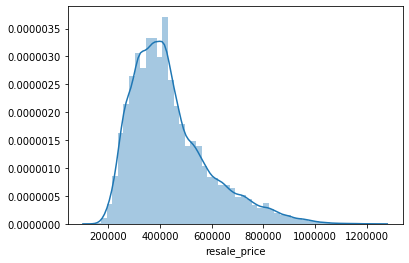

In [37]:
sns.distplot(y_train)

Seems that it is **skewed to the right**. Let's use a log transformation so that we get a more 'normal' distribution

In [38]:
y_train = np.log(1+y_train)

In [39]:
y_test_log = np.log(1+y_test)

In [40]:
#Ordinary least squares regression without normalisation

lr = LinearRegression()
lr.fit(X_train,y_train)
y_hat = lr.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, np.exp(y_hat)-1)) / y_test.mean())
print(r2_score(np.log(1+y_test), y_hat))

0.12271203409555463
0.8858897237072658


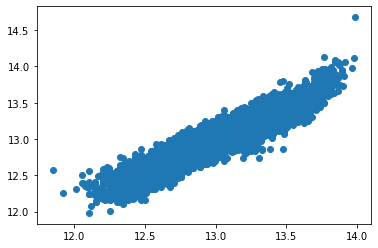

In [41]:
plt.scatter(np.log(1 + y_test),y_hat)

In [42]:
#with normalisation

lr2 = LinearRegression()
lr2.fit(X_train_norm,y_train)
y_hat_norm = lr2.predict(X_test_norm)
print(math.sqrt(mean_squared_error(y_test, np.exp(y_hat_norm)-1)) / y_test.mean())
print(r2_score(np.log(1+y_test), y_hat_norm))

0.12271727727188157
0.8858860783957321


The results are similar for ordinaly least squares regression, but for further analysis let's use the normalised datset.

## Building Models

We will use the follwing models for our analysis

1. Ridge Regression
2. Lasso Regression
3. Decision Tree Regressor
4. Random Forest Regressor
5. Gradient Boosting Regressor
5. XGBoost Regressor

We will use a multifold cross validation approach using grid search to tune the hyperparameters

We will use the R2 value to estimate the best hyperparameter. We will also keep track of the coefficient of variation (RMS/mean) as a measure of the average error in our prediction and thus an estimate of the performance. Please note that R2 value will be our single evaluation metric on which the model selection will be made and the COV value will not be used for model selection.

## 1. Ridge Regression                       

For Ridge, we will use the Ridge CV which has built in cross validation functionality

In [43]:
#dictionary to store the R2 scores and COV
scores = {}

#function to compute scores
def score(y_hat):
    cov = np.sqrt(mean_squared_error(y_test, np.exp(y_hat)-1)) / y_test.mean()
    r2 = r2_score(y_test_log, y_hat)
    result = (r2, cov)
    return result

In [45]:
from sklearn.linear_model import RidgeCV
clf = RidgeCV(cv = 4, alphas=[0.001, 0.003, 0.01 , 0.03, 0.1, 0.3, 1]).fit(X_train, y_train)

In [46]:
print('The best hyperparameter is alpha ', str(clf.alpha_), 'with and R2 score of', str(clf.best_score_))

The best hyperparameter is alpha  0.03 with and R2 score of 0.8831607570580318


In [47]:
y_hat_R = clf.predict(X_test)
print(score(y_hat_R))
scores['Ridge'] = score(y_hat_R)

(0.8858918147523764, 0.12270819358967232)


## 2. Lasso Regression

In [48]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
lasso = linear_model.Lasso()
p_lasso = {'alpha':(0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1 )}
grid_lasso = GridSearchCV(lasso, p_lasso, cv=4)
grid_lasso.fit(X_train_norm,y_train)

GridSearchCV(cv=4, estimator=Lasso(),
             param_grid={'alpha': (0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1)})

In [49]:
print('The best hyperparameter set is', str(grid_lasso.best_params_), 'with an R2 score of', str(grid_lasso.best_score_))

The best hyperparameter set is {'alpha': 0.001} with an R2 score of 0.8825303427616217


In [50]:
## making predictions and checking the performance on the test set
y_hat_Lasso = grid_lasso.predict(X_test_norm)
print(score(y_hat_Lasso))
scores['Lasso'] = score(y_hat_Lasso)

(0.885240999942356, 0.12245624939959383)


## 3. Decision Tree Regressor

In [51]:
from sklearn.tree import DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=1)
p_dtr = {'max_depth':[1,2,3,4,5,6,7,8,9,10, None]}
grid_dtr = GridSearchCV(dtr, p_dtr, cv=4)
grid_dtr.fit(X_train_norm,y_train)

GridSearchCV(cv=4, estimator=DecisionTreeRegressor(random_state=1),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None]})

In [52]:
grid_dtr.best_params_

{'max_depth': None}

In [53]:
print('The best hyperparameter is max depth set as None with an R2 score of', str(grid_dtr.best_score_))

The best hyperparameter is max depth set as None with an R2 score of 0.8990334818130707


In [54]:
## making predictions and checking the performance on the test set
y_hat_dtr = grid_dtr.predict(X_test_norm)
print(score(y_hat_dtr))
scores['Decision Tree'] = score(y_hat_dtr)

(0.9070696036470141, 0.10579762537587199)


## 4. Random Forest Regressor

In [55]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_jobs = 16, verbose = 2)
p_rfr = {'n_estimators':[3, 10, 30, 100]}
grid_rfr = GridSearchCV(rfr, p_rfr, cv=4)
grid_rfr.fit(X_train_norm,y_train)

[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    1.1s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   3 out of   3 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  

building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100building tree 14 of 100

building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100


[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    1.1s


building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100building tree 44 of 100

building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100building tree 53 of 100
building tree 54 of 100

building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70

[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    6.5s finished


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=16, verbose=2),
             param_grid={'n_estimators': [3, 10, 30, 100]})

In [56]:
print('The best hyperparameter set is', str(grid_rfr.best_params_), 'with and R2 score of', str(grid_rfr.best_score_))

The best hyperparameter set is {'n_estimators': 100} with and R2 score of 0.9350417711826717


In [57]:
## making predictions and checking the performance on the test set
y_hat_rfr = grid_rfr.predict(X_test_norm)
print(score(y_hat_rfr))
scores['Random Forest'] = score(y_hat_rfr)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done   9 tasks      | elapsed:    0.1s


(0.9381809109637962, 0.08528857793143793)


[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.2s finished


## 5. Gradient Boosting Regressor

In [58]:
from sklearn.ensemble import GradientBoostingRegressor
#let's use estimators as 100 as GBM is robust to overfitting and a higher number usually leads to better performance
gbm = GradientBoostingRegressor(n_estimators = 100, verbose = 1) 
#let's try to tune the max_depth hyperparameter
p_gbm = {'max_depth':[3, 5, 8, 10]}                        #, 'loss':['ls', 'lad', 'huber'], 'learning_rate':[0.01, 0.03, 0.1, 0.3]
grid_gbm = GridSearchCV(gbm, p_gbm, cv=4, verbose=2) 
grid_gbm.fit(X_train_norm,y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] max_depth=3 .....................................................
      Iter       Train Loss   Remaining Time 
         1           0.0961            7.84s
         2           0.0866            7.18s
         3           0.0788            7.17s
         4           0.0723            6.92s
         5           0.0668            6.75s
         6           0.0623            6.61s
         7           0.0583            6.60s
         8           0.0550            6.50s
         9           0.0520            6.40s
        10           0.0496            6.39s
        20           0.0348            5.65s
        30           0.0279            4.95s
        40           0.0238            4.33s
        50           0.0207            3.63s
        60           0.0186            2.92s
        70           0.0169            2.19s
        80           0.0157            1.47s
        90           0.0147            0.74s
       100   

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.5s remaining:    0.0s


         3           0.0789            6.53s
         4           0.0724            6.48s
         5           0.0668            6.39s
         6           0.0623            6.29s
         7           0.0583            6.27s
         8           0.0550            6.34s
         9           0.0520            6.30s
        10           0.0496            6.25s
        20           0.0347            5.51s
        30           0.0280            4.96s
        40           0.0236            4.31s
        50           0.0207            3.63s
        60           0.0187            2.93s
        70           0.0171            2.21s
        80           0.0158            1.48s
        90           0.0148            0.74s
       100           0.0137            0.00s
[CV] ...................................... max_depth=3, total=   7.5s
[CV] max_depth=3 .....................................................
      Iter       Train Loss   Remaining Time 
         1           0.0960            6.53s
  

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  3.4min finished


         1           0.0910           16.29s
         2           0.0774           16.26s
         3           0.0663           16.07s
         4           0.0570           15.79s
         5           0.0494           15.65s
         6           0.0430           15.52s
         7           0.0377           15.35s
         8           0.0332           15.15s
         9           0.0296           14.97s
        10           0.0265           14.82s
        20           0.0122           13.47s
        30           0.0083           11.72s
        40           0.0067           10.03s
        50           0.0058            8.35s
        60           0.0054            6.68s
        70           0.0050            5.02s
        80           0.0047            3.35s
        90           0.0045            1.68s
       100           0.0043            0.00s


GridSearchCV(cv=4, estimator=GradientBoostingRegressor(verbose=1),
             param_grid={'max_depth': [3, 5, 8, 10]}, verbose=2)

In [59]:
print('The best hyperparameter set is', str(grid_gbm.best_params_), 'with and R2 score of', str(grid_gbm.best_score_))

The best hyperparameter set is {'max_depth': 10} with and R2 score of 0.9409929753193134


In [60]:
## making predictions and checking the performance on the test set
y_hat_gbm = grid_gbm.predict(X_test_norm)
print(score(y_hat_gbm))
scores['Gradient Boosting'] = score(y_hat_gbm)

(0.943542194946397, 0.08241584830845249)


## 6. XGBoost Regressor

In [61]:
import xgboost as xgb

In [62]:
xgbr = xgb.XGBRegressor()
p_xgbr = {'max_depth':[3, 5, 8, 10], 'n_estimators':[100,500,1000], 'learning_rate':[0.05,0.1,0.2,0.3]}  
grid_xgbr = GridSearchCV(xgbr, p_xgbr, cv=4, verbose=2) 
grid_xgbr.fit(X_train_norm,y_train)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
[CV] learning_rate=0.05, max_depth=3, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, total=   1.3s
[CV] learning_rate=0.05, max_depth=3, n_estimators=100 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, total=   1.2s
[CV] learning_rate=0.05, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, total=   1.2s
[CV] learning_rate=0.05, max_depth=3, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=100, total=   1.2s
[CV] learning_rate=0.05, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=500, total=   5.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=500, total=   5.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=500, total=   5.4s
[CV] learning_rate=0.05, max_depth=3, n_estimators=500 ...............
[CV]  learning_rate=0.05, max_depth=3, n_estimators=500, total=   5.5s
[CV] learning_rate=0.05, max_depth=3, n_estimators=1000 ..............
[CV]  

[Parallel(n_jobs=1)]: Done 192 out of 192 | elapsed: 42.5min finished


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_para

In [63]:
print('The best hyperparameter set is', str(grid_xgbr.best_params_), 'with and R2 score of', str(grid_xgbr.best_score_))

The best hyperparameter set is {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 1000} with and R2 score of 0.9446376764447706


In [64]:
## making predictions and checking the performance on the test set
y_hat_xgb = grid_xgbr.predict(X_test_norm)
print(score(y_hat_xgb))
scores['XGBoost'] = score(y_hat_xgb)

(0.9476239695586313, 0.07868149984095228)


## **Results and Discussion**

First let's plot the R2 value on the dev set obtained (actually the mean value across the multiple folds) for the different models. We have stored the R2 values and COV values in a dictionary.

In [65]:
scores

{'Ridge': (0.8858918147523764, 0.12270819358967232),
 'Lasso': (0.885240999942356, 0.12245624939959383),
 'Decision Tree': (0.9070696036470141, 0.10579762537587199),
 'Random Forest': (0.9381809109637962, 0.08528857793143793),
 'Gradient Boosting': (0.943542194946397, 0.08241584830845249),
 'XGBoost': (0.9476239695586313, 0.07868149984095228)}

In [66]:
#fetching the values from the dictionary to create the plot
x = [key for key in scores.keys()]
y = [scores[key][0] for key in scores.keys()]

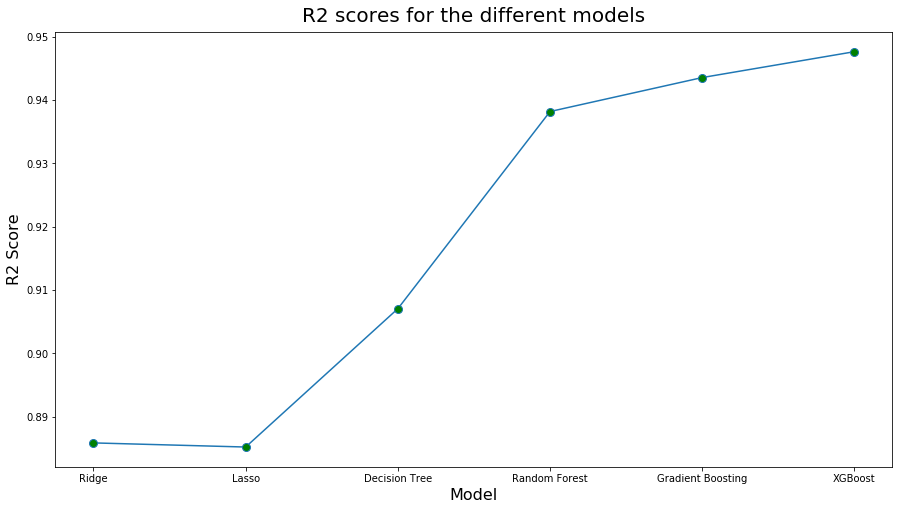

In [67]:
plt.figure(figsize=(15,8))
plt.title('R2 scores for the different models', fontdict={'fontsize':20}, pad=10)
plt.xlabel('Model', fontdict={'fontsize':16})
plt.ylabel('R2 Score', fontdict={'fontsize':16})
plt.plot(x, y, marker='o', markerfacecolor='green', markersize=8)

As observed, the **XGBoost algorithm** performs the best with an R2 score of around **0.95**. An important point to note is that there is a significant improvement when using ensemble learning methods like Random Forests, GBM and XGBoost.

Another point to note is that the performance of gradient boosting methods is similar to that of Random Forest, as only a 0.5 - 1 % improvement is shown by GBM and XGBoost.

Let's also check the coefficient of variation values which will give an indication of the average error of the predictions from the average values.

In [68]:
z = [scores[key][1]*100 for key in scores.keys()]

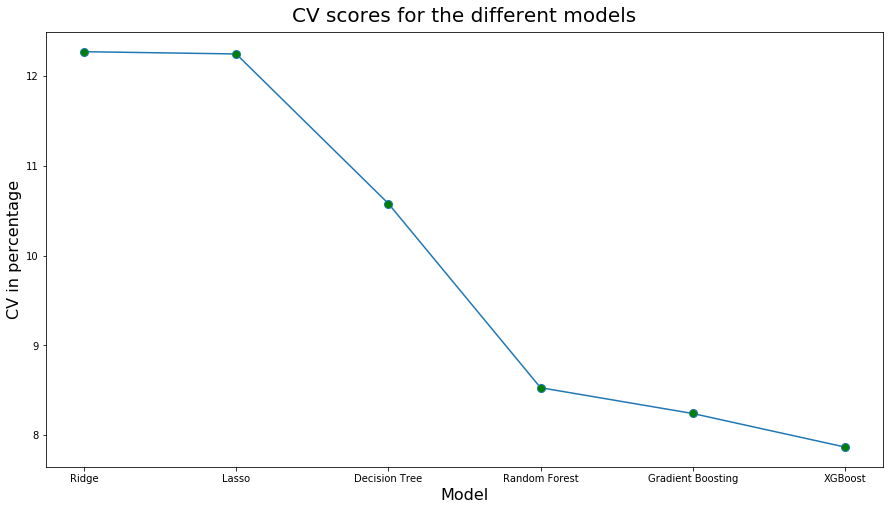

In [69]:
plt.figure(figsize=(15,8))
plt.title('CV scores for the different models', fontdict={'fontsize':20}, pad=10)
plt.xlabel('Model', fontdict={'fontsize':16})
plt.ylabel('CV in percentage', fontdict={'fontsize':16})
plt.plot(x, z, marker='o', markerfacecolor='green', markersize=8)

It can be seen that the XGboost has a CV of around 1.5 times lower than that of Ridge and Lasso Regressions.

## Conclusion

Based on our modelling and analysis, we will use the **XGBoost model for our flat resale price predictor**. It performs best on the test set with an **R2 score** of **0.9476**